# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*My name is Inigo Montoya. You killed my father. Prepare to die.*' has the following 3-grams:

* 'my name is'
* 'name is inigo'
* 'is inigo montoya'
* ...
* 'my father prepare'
* 'father prepare to'
* 'prepare to die'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

# 0. Preliminaries

The corpus you will use is a file named `EstamosPorTi.json.gz`. The file contain about 16,800 Twitter messages ("tweets") posted between October 1st, 2017, and October 24th, 2017, and using the hashtag `#EstamosPorTi`. Background information on this collection is available on [the Internet Archive](https://archive.org/details/EstamosporTIOohmm2018032618831Ids). In Twitter there are many near-duplicates because of re-tweets and because people quote each other.

## 0.1 Required imports

We will use the following libraries:

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
from timeit import default_timer as timer
import datetime
import matplotlib.pyplot as plt

## 0.2 Read the tweet content into an array of messages

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). Python's JSON library takes care of translating it into a dictionary. Finally, this is a gzip-compressed file, which you can de-compress using the `gunzip` command, or read compressed using the `gzip` library.

In [2]:
INPUT_FILENAME = "Datasets/EstamosPorTi.json.gz"

messages = []

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    for line in input_file:
        tweet = json.loads(line)
        author = tweet["user"]["screen_name"]
        message = tweet["full_text"]
        messages.append(message)
        
print("Read %d documents" % len(messages))

Read 16853 documents


In [3]:
# Uncomment the next line if you want to work with a smaller set temporarily, this might help you during development

#messages = ["hello I am your neighbor", "hello I am john", "I am john the carpenter", "john the carpenter is your neighbor"]

# 1. Implement auxiliary functions

[**CODE**] Implement the Jaccard similarity between two lists: the size of the intersection of two sets, divided by the size of their union. Tip: use `set(l)` to convert list `l` to a set. Then you can use `s1.union(s2)` and `s1.intersection(s2)` if `s1` and `s2` are sets.

In [4]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(set(list2))))
    union = len(set(list1).union(set(list2)))
    
    return float(intersection / union)

Test your function:

In [5]:
print(jaccard_similarity(['a', 'b', 'c'], ['a', 'c', 'd']))
print(jaccard_similarity(['a', 'b', 'c'], ['d', 'e', 'f']))

0.5
0.0


[**CODE**] Implement a simple function to clean-up text by converting to lowercase and removing anything that is not a letter or digit. Tip: use `text.lower()` to convert to lowercase, and `re.sub(...)` to replace parts of the text.

In [6]:
def clean(text):
    text = text.lower()
    text = re.sub(r'[!?.,¿¡:\'@#0123456789]', '', text)
    return text

Test your function:

In [7]:
print(clean("I am Iñigo Montoya!"))

i am iñigo montoya


# 2. Implement an n-gram extractor

[**CODE**] Implement the function `ngrams(text,size)`, which should produce all sub-sequences of `size` words present in the text.

In [8]:
def ngrams(text, size):
    tokens = text.split()
    ngrams = []    
    #Special case for when the text is smaller than the size
    if len(tokens) < size:
        return tokens
    else:
        ngrams = zip(*[tokens[i:] for i in range(size)])
        return [" ".join(ngram) for ngram in ngrams]

Test your function:

In [9]:
for docid in range(3):
    print()
    print("Docid   : %d" % docid)
    print("Message : %s" % clean(messages[docid]))
    print("Ngrams  : [%s]" % ", ".join(ngrams(clean(messages[docid]), 3)))


Docid   : 0
Message : rt lavanguardia último tuit del ministerio de interior catalanreferendum https//tco/wkloawtu
Ngrams  : [rt lavanguardia último, lavanguardia último tuit, último tuit del, tuit del ministerio, del ministerio de, ministerio de interior, de interior catalanreferendum, interior catalanreferendum https//tco/wkloawtu]

Docid   : 1
Message : rt julianassange heres spains interior ministry bragging that its military police have have sabotaged access to the catalan government…
Ngrams  : [rt julianassange heres, julianassange heres spains, heres spains interior, spains interior ministry, interior ministry bragging, ministry bragging that, bragging that its, that its military, its military police, military police have, police have have, have have sabotaged, have sabotaged access, sabotaged access to, access to the, to the catalan, the catalan government…]

Docid   : 2
Message : rt julianassange heres spains interior ministry bragging that its military police have have sabot

# 3. Estimate how long it would take to compare all messages

Use the following code to estimate how long would it take to perform pair-wise comparisons between the sets of ngrams of all the documents.

In [34]:
limit = 100

start = timer()

for docid1 in range(len(messages)):
    if docid1 > limit:
        break
        
    doc1 = clean(messages[docid1])
    ngrams1 = ngrams(doc1, 3)
    
    for docid2 in range(docid1+1, len(messages)):
        doc2 = clean(messages[docid2])
        ngrams2 = ngrams(doc2, 3)
        
        similarity = jaccard_similarity(ngrams1, ngrams2)
            
end = timer()

[**REPORT**] Include the following time estimations in your report

In [35]:
print("Scanning %d messages took %s" % (limit, datetime.timedelta(seconds=end-start)))
print("Scanning %d messages would take %s" % (len(messages), datetime.timedelta(seconds=(end-start)*len(messages)/limit)))

Scanning 100 messages took 0:01:03.940472
Scanning 16853 messages would take 2:59:35.887797


# 2. Compute doc-ngram matrix

Now we will compute a matrix in which every row is an ngram, and every column is a document.

This normally done by hashing the ngrams and then every row is an ngram *hash*; in this practice we will skip that step and work directly with one ngram per row, which is conceptually the same and easier to code.

## 2.1 Create list of all ngrams

[**CODE**] Implement code to create the dictionary `ngram_to_index`, which should convert an ngram to an index (a row number) and to create the variable `num_distinct_ngrams` which should contain the number of distinct ngrams.

In [12]:
ngram_size = 3

ngram_to_index = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(clean(message), ngram_size)
    for ngram_str in all_ngrams:
        if ngram_str not in ngram_to_index:
            ngram_to_index[ngram_str] = next_index
            next_index += 1
            
num_distinct_ngrams = next_index

Test your function. The exact number of total n-grams may vary depending on how you `clean()` text.

In [13]:
print("Total number of %d-grams: %d" % (ngram_size, num_distinct_ngrams))
print(ngram_to_index["hoy a dormir"])
print(ngram_to_index["universal census system"])

Total number of 3-grams: 20220
15573
15016


## 2.2 Create table ngrams x documents

In the matrix `M_ngram_doc`, each row should be an n-gram, and each column should be a document.

In [14]:
M_ngram_doc = np.zeros((num_distinct_ngrams, len(messages)))
print("Rows: %d (distinct shingles)" % len(M_ngram_doc))
print("Columns: %d (distinct documents)" % len(M_ngram_doc[0]))

Rows: 20220 (distinct shingles)
Columns: 16853 (distinct documents)


[**CODE**] Complete the matrix `M_ngram_doc` so that position i, j (row, column) holds a 1 if document j contains ngram i, otherwise holds a 0.

In [15]:
for docid in range(len(messages)):
    message = messages[docid]
    ngram_message = ngrams(message, ngram_size)
    all_ngrams = ngrams(clean(message), ngram_size)
    for ngram_str in all_ngrams:
        ngram_index = ngram_to_index[ngram_str]
        M_ngram_doc[ngram_index, docid] = 1

Check a couple of documents (columns). All columns should be very sparse, i.e., mostly zeroes.

In [16]:
print("Positions of non-zeros in column of docid 28 of M_ngram_doc")
print("Message   : %s" % clean(messages[28]))
ngrams_doc_28 = [i for i in range(num_distinct_ngrams) if M_ngram_doc[i, 28] == 1.0]
print("Non-zeros : %s" % ngrams_doc_28)

print()

print("Positions of non-zeros in column of docid 3689 of M_ngram_doc")
print("Message   : %s" % clean(messages[3689]))
ngrams_doc_3689 = [i for i in range(num_distinct_ngrams) if M_ngram_doc[i, 3689] == 1.0]
print("Non-zeros : %s" % ngrams_doc_3689)

Positions of non-zeros in column of docid 28 of M_ngram_doc
Message   : rt policia agentes intervienen urnas y papeletas en distintos colegios de barcelona cumplimos la legalidad 
estamosporti https//tco/…
Non-zeros : [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]

Positions of non-zeros in column of docid 3689 of M_ngram_doc
Message   : rt noticia_libre agentes policia  intervienen urnas y papeletas en distintos colegios de barcelona cumplimos la legalidad 
estamospor…
Non-zeros : [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 2854, 2855, 2856, 2857, 2858]


# 3. Implement a permutation generator

[**CODE**] Implement the function `random_permutation(k)`, which should generate a random permutation of the array `[0, 2, 3, ..., k-1]`. Tip: the function `random.shuffle(...)` might be useful, and if you want to use `range(...)`, which returns an iterator, you will need to convert it to a list using `list(range(...))`.

In [17]:
def random_permutation(k):
    arr = np.arange(k)
    np.random.shuffle(arr)
    return arr.tolist()

Test your function. Every number between *0* and *k-1* should be in the permutation once, and every call to the function should generate a new permutation.

In [18]:
print(random_permutation(20))
print(random_permutation(20))

[7, 15, 9, 12, 6, 8, 17, 4, 0, 14, 3, 19, 2, 11, 13, 16, 5, 1, 18, 10]
[12, 8, 2, 1, 17, 0, 11, 19, 7, 9, 3, 15, 16, 6, 13, 5, 14, 10, 4, 18]


Further test this by applying the same permutation on two lists.

In [19]:
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

original_list_1 = ["a", "b", "c", "d", "e"]
original_list_2 = ["alpha", "beta", "gamma", "delta", "epsilon"]

permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

['c', 'd', 'e', 'a', 'b']
['gamma', 'delta', 'epsilon', 'alpha', 'beta']
['a', 'b', 'c', 'e', 'd']
['alpha', 'beta', 'gamma', 'epsilon', 'delta']


# 4. Compute the signature of each document

Now comes the core of the algorith. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

In [20]:
num_permutations = 4

[**CODE**] Create *num_permutation* permutations and store them in the array of arrays `permutations`.

In [21]:
permutations = []

print("Creating %d permutations for %d distinct ngrams" % (num_permutations, num_distinct_ngrams))
for i in range(num_permutations):
    permutations.append(random_permutation(num_distinct_ngrams))

Creating 4 permutations for 20220 distinct ngrams


Test by printing the permutations you have created:

In [22]:
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 17232, 11556, 725, ...
Permutation 1: 18861, 15658, 5977, ...
Permutation 2: 4173, 5613, 3746, ...
Permutation 3: 8823, 12441, 2222, ...


[**CODE**] Implement the signature construction. The matrix `M_signature_doc` should contain in row i, column j, the first ngram (the "minimum" one) that is present in a column (document), according to the order given by a permutation.

In [23]:
M_signature_doc = np.zeros((num_permutations, len(messages)))

def find_smallest_ngram_permutation_order(docid, permutation):
    for ngram_id in permutation:
        if M_ngram_doc[ngram_id, docid] == 1:
            return ngram_id
    return -1

for permutation_num in range(num_permutations):
    print("Creating signatures for permutation %d/%d" % (permutation_num, num_permutations))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        M_signature_doc[permutation_num, docid] = find_smallest_ngram_permutation_order(docid, permutations[permutation_num])
        

Creating signatures for permutation 0/4
Creating signatures for permutation 1/4
Creating signatures for permutation 2/4
Creating signatures for permutation 3/4


Test your code by checking the signatures of two documents that are near-duplicates. Being near-duplicates, we expect these should have many ngrams in common, and hence, with high probability they will have many elements in common in their signatures.

In [24]:
print("Signature of document 28")
print("Message   : %s" % clean(messages[28]))
print("Ngrams    : %s" % ngrams_doc_28)
signature_28 = [M_signature_doc[i, 28] for i in range(num_permutations)]
print("Signature : %s" % signature_28)

print()

print("Signature of document 3689")
print("Message   : %s" % clean(messages[3689]))
print("Ngrams    : %s" % ngrams_doc_3689)
signature_3689 = [M_signature_doc[i, 3689] for i in range(num_permutations)]
print("Signature : %s" % signature_3689)

Signature of document 28
Message   : rt policia agentes intervienen urnas y papeletas en distintos colegios de barcelona cumplimos la legalidad 
estamosporti https//tco/…
Ngrams    : [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
Signature : [71.0, 66.0, 76.0, 65.0]

Signature of document 3689
Message   : rt noticia_libre agentes policia  intervienen urnas y papeletas en distintos colegios de barcelona cumplimos la legalidad 
estamospor…
Ngrams    : [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 2854, 2855, 2856, 2857, 2858]
Signature : [71.0, 66.0, 2856.0, 69.0]


# 5. Compare all pair-wise signatures

Now we are ready to compare all documents by their signatures, instead of by their content.

In [25]:
def extract_signature(docid):
    return [M_signature_doc[i, docid] for i in range(num_permutations)]

In [26]:
limit = 100

start = timer()

for docid1 in range(len(messages)):
    if docid1 > limit:
        break
    
    signature1 = extract_signature(docid1)        
    for docid2 in range(docid1+1, len(messages)):
        signature2 = extract_signature(docid2)
        
        similarity = jaccard_similarity(signature1, signature2)
        
end = timer()

[**REPORT**] Include the following time estimations in your report

In [27]:
print("Scanning %d took %s" % (limit, datetime.timedelta(seconds=end-start)))
print("Scanning %d would take %s" % (len(messages), datetime.timedelta(seconds=(end-start)*len(messages)/limit)))

Scanning 100 took 0:00:12.596550
Scanning 16853 would take 0:35:22.896571


# 7. Compute percentage of pairs having the following similarities

[**CODE**] [**REPORT**] Implement code to compute and report: what percentage of pairs have similarity strictly greater than 0.5 but strictly less than 1.0; give 2-3 examples of them (include docids and texts).

[**CODE**] [**REPORT**] Implement code to compute and report: what percentage of pairs of documents have similarity 1.0, give 2-3 examples of them (include docids and texts).

[**CODE**] [**REPORT**] Implement code to compute and report: what is the document that has more duplicates (give the docid and its text).

Idea: you can save time by implementing these three in a single pass doing two nested loops over the messages (as above), instead of implementing these as three separate passes.

In [28]:
#CREATE MATRIX OF RELATION AND FILLING IT
similarities = np.zeros((len(messages), len(messages)))

for docid1 in range(len(messages)):
    signature1 = extract_signature(docid1)        
    for docid2 in range(docid1+1, len(messages)):
        signature2 = extract_signature(docid2)        
        similarity = jaccard_similarity(signature1, signature2)
        similarities[docid1, docid2] = similarity
        similarities[docid2, docid1] = similarity
print(similarities)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


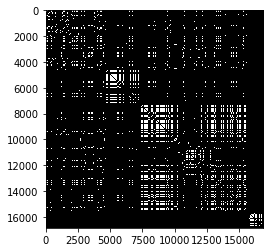

In [29]:
#Like a correlation matrix but with the similarities between documents
plt.imshow(similarities, cmap="gray")
plt.show()

In [30]:
counter_equal = 0
counter_half = 0
counter_row = 0

for column in range(len(messages)):
    counter_row = 0
    for row in range(len(messages)):
        if similarities[column, row] == 1:
            counter_row += 1
            if(counter_equal<3):
                print('The document', column, 'and', row, 'are equals (100%)')
                print(column, ':', messages[column])
                print(row, ':', messages[row])
            counter_equal += 1            
        elif similarities[column, row] > .5 and similarities[column, row] < 1:
            if(counter_half<3):
                print('The document', column, 'and', row, 'are similars (>50%)')
                print(column, ':', messages[column])
                print(row, ':', messages[row])
            counter_half += 1

The document 0 and 46 are equals (100%)
0 : RT @LaVanguardia: Último tuit del Ministerio de Interior #CatalanReferendum https://t.co/Wk33Loawtu
46 : RT @LaVanguardia: Último tuit del Ministerio de Interior #CatalanReferendum https://t.co/Wk33Loawtu
The document 0 and 119 are equals (100%)
0 : RT @LaVanguardia: Último tuit del Ministerio de Interior #CatalanReferendum https://t.co/Wk33Loawtu
119 : RT @LaVanguardia: Último tuit del Ministerio de Interior #CatalanReferendum https://t.co/Wk33Loawtu
The document 0 and 2081 are equals (100%)
0 : RT @LaVanguardia: Último tuit del Ministerio de Interior #CatalanReferendum https://t.co/Wk33Loawtu
2081 : RT @LaVanguardia: Último tuit del Ministerio de Interior #CatalanReferendum https://t.co/Wk33Loawtu
The document 100 and 1622 are similars (>50%)
100 : RT @interiorgob: @policia @guardiacivil 2-Estas son las primeras urnas y papeletas incautadas por @policia, en Barcelona. Los agentes conti…
1622 : RT @ANDRES_CANO42: #UnDomingoLegal   Estas son 

In [31]:
duplicates = []
for row in range(len(similarities)):
    duplicates.append(np.count_nonzero(similarities[row] == 1.0))
print('The document with more duplicates is:\n', messages[np.argmax(duplicates)], '\nwith', np.max(duplicates), 'duplicates')

The document with more duplicates is:
 RT @interiorgob: Agentes de @policia también se han encontrado con agresiones,como esta en Barcelona,violencia contra el cumplimiento de la… 
with 3559 duplicates


In [32]:
print('Identical Documents:', (counter_equal/len(messages)**2)*100,'%') 
print('Similar Documents:', (counter_half/len(messages)**2)*100, '%')

Identical Documents: 7.316453752969529 %
Similar Documents: 0.012345452592287847 %


# 8. Deliver

Deliver:

* A zip file containing your notebook (.ipynb file) with all the [**CODE**] parts implemented.
* A 1-page PDF report including all parts of this notebook marked with "[**REPORT**]"

The report should end with the following statement: **I hereby declare that, except for the code provided by the course instructors, all of our code, report, and figures were produced by myself.**